In [58]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')

if iskaggle:
    path = Path('../input/titanic')
    ! pip install -Uqq fastai

else:
    import zipfile, kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [59]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [60]:
df = pd.read_csv(path/'train.csv')

In [61]:
def add_features(df):
    df['logFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A='ABC', B='ABC', C='ABC', D='DE', E='FG', G='FG'))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand = True)[1].str.split('.', expand = True)[0]
    df['Title'] = df.Title.map(dict(Mr='Mr', Miss = 'Miss', Mrs = 'Mrs', Master = 'Master'))


add_features(df)

In [62]:
splits = RandomSplitter(seed=42)(df)

In [65]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'logFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

c:\Users\INDIA\anaconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [67]:
learn = tabular_learner(dls, metrics = accuracy, layers=[10,10])

c:\Users\INDIA\anaconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwa

SuggestedLRs(slide=0.05754399299621582, valley=0.005248074419796467)

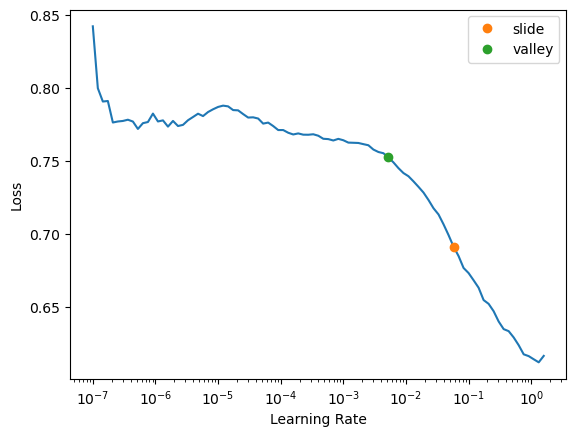

In [68]:
learn.lr_find(suggest_funcs=(slide, valley))

In [69]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.582907,0.560340,0.634831,00:00
1,0.510967,0.467397,0.820225,00:00
2,0.479038,0.485063,0.808989,00:00
3,0.444424,0.399074,0.859551,00:00
4,0.435874,0.413704,0.848315,00:00
5,0.419469,0.408400,0.808989,00:00
6,0.407843,0.494986,0.814607,00:00
7,0.412316,0.457805,0.808989,00:00
8,0.402415,0.419771,0.837079,00:00
9,0.411569,0.427652,0.825843,00:00


In [70]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [71]:
tst_dl = learn.dls.test_dl(tst_df)

c:\Users\INDIA\anaconda3\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [72]:
preds, _ = learn.get_preds(dl = tst_dl)

In [73]:
tst_df['Survived'] = (preds[:, 1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [ ]:
! head sub.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


In [79]:
def ensemble():
    learn = tabular_learner(dls, metrics = accuracy, layers=[10,10])
    with learn.no_bar(), learn.no_logging(): learn.fit(16, lr=0.03)

    return learn.get_preds(dl=tst_dl)[0]

In [80]:
learns = [ensemble() for _ in range(5)]

In [81]:
ens_preds = torch.stack(learns).mean(0)

In [82]:
tst_df['Survived'] = (ens_preds[:, 1]>0.5).int()
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('ens_sub.csv', index = False)